D1114_WORK_김현우 <hr>

1. 목적
- 센서 기반 제조 품질 검사 데이터를 분석하여 불량을 유발하는 요인을 찾고, 품질 개선을 위한 인사이트를 도출

2. 데이터
- smart_quality_inspection_dataset.csv
- 자동차 부품 품질 검사 데이터
- 컬럼

3. 도출 결과
- 각 결함 유형별 어떤 센서 특성과 표면 패턴 특징 가지는지
- 센서 값만으로 결함 유형 예측 가능한지
- 공정 개선 제안 1개 이상

In [82]:
# ---------------------------------------------------------------------------
# 컬럼명                       설명
# ---------------------------------------------------------------------------
# HOG_F1 ~ HOG_F10   HOG(Histogram of Oriented Gradients) 기반 피쳐
#                    이미지/표면 패턴 특성을 수치로 변환한 값
# Temperature        공정 온도 센서 값
# Vibration          진동 센서 값
# Acoustic           소음 센서 값
# Fault_Type         불량 종류 (Surface Crack, Dent, Overheating, No Fault 등)
# ---------------------------------------------------------------------------

모듈 및 데이터 로딩 <hr>

In [83]:
# -----------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
# -----------------------------------------------------------------
FILE_NAME = '../D1114/smart_quality_inspection_dataset.csv'
dataDF = pd.read_csv(FILE_NAME)

데이터 확인 <hr>

In [84]:

print(f"\n✓ 데이터셋 크기: {dataDF.shape}")
print(f"\n✓ 컬럼명:\n{dataDF.columns.tolist()}")
print(f"\n✓ 데이터 타입:\n{dataDF.dtypes}")
print(f"\n✓ 첫 5개 행:\n{dataDF.head()}")


✓ 데이터셋 크기: (1854, 14)

✓ 컬럼명:
['HOG_F1', 'HOG_F2', 'HOG_F3', 'HOG_F4', 'HOG_F5', 'HOG_F6', 'HOG_F7', 'HOG_F8', 'HOG_F9', 'HOG_F10', 'Temperature', 'Vibration', 'Acoustic', 'Fault_Type']

✓ 데이터 타입:
HOG_F1         float64
HOG_F2         float64
HOG_F3         float64
HOG_F4         float64
HOG_F5         float64
HOG_F6         float64
HOG_F7         float64
HOG_F8         float64
HOG_F9         float64
HOG_F10        float64
Temperature    float64
Vibration      float64
Acoustic       float64
Fault_Type      object
dtype: object

✓ 첫 5개 행:
     HOG_F1    HOG_F2    HOG_F3    HOG_F4    HOG_F5    HOG_F6    HOG_F7  \
0  0.046846  0.747276 -0.115297 -0.920363 -1.195644 -0.953782 -1.143734   
1 -0.086770  1.413315  0.429374  0.424495  0.174386  0.275093  0.322255   
2 -0.536923  0.184367 -1.079265 -1.473758 -1.279324 -0.073878 -1.615569   
3 -0.369409 -0.483601  0.296536  0.596621  0.296258 -1.310473 -0.189909   
4  0.525870 -0.312140 -0.311123  1.108442 -0.053811 -0.473454 -0.308574   

    

결측치 처리 <hr>
✓ 결측치 확인 결과 모두 정상

In [85]:
print(f"✓ 결측치 확인: \n{dataDF.isnull().sum()}")

✓ 결측치 확인: 
HOG_F1         0
HOG_F2         0
HOG_F3         0
HOG_F4         0
HOG_F5         0
HOG_F6         0
HOG_F7         0
HOG_F8         0
HOG_F9         0
HOG_F10        0
Temperature    0
Vibration      0
Acoustic       0
Fault_Type     0
dtype: int64


중복값 처리 <hr>
✓ 중복값 확인 결과 모두 정상

In [ ]:
print(f"✓ 중복 데이터 확인: \n{dataDF.duplicated().sum()}")

✓ 중복 데이터 확인: 
0


데이터 통계 정보 <hr>

In [87]:
print(f"✓ 숫자형 데이터 통계: \n{dataDF.describe().to_string()}\n")
      
print(f"✓ 불량 타입 분석: \n{dataDF['Fault_Type'].value_counts()}")

✓ 숫자형 데이터 통계: 
            HOG_F1       HOG_F2       HOG_F3       HOG_F4       HOG_F5       HOG_F6       HOG_F7       HOG_F8       HOG_F9      HOG_F10  Temperature    Vibration     Acoustic
count  1854.000000  1854.000000  1854.000000  1854.000000  1854.000000  1854.000000  1854.000000  1854.000000  1854.000000  1854.000000  1854.000000  1854.000000  1854.000000
mean      0.007511     0.005424     0.021024    -0.007397    -0.010008     0.036029     0.017027    -0.000847    -0.010239     0.006953    66.850375     6.582042    53.174158
std       1.046899     1.015924     0.990626     1.005499     0.994329     0.981144     0.979579     0.959864     1.024007     0.964515    16.524104     3.805618    16.462969
min      -3.404486    -3.342404    -3.264831    -3.107820    -3.375559    -3.133530    -3.521808    -3.967711    -4.186148    -3.029159    31.005898    -0.814874     3.888350
25%      -0.697087    -0.684571    -0.687283    -0.694222    -0.708480    -0.620500    -0.660615    -0.666945 

데이터 전처리 <hr>

In [88]:
# 원본 데이터 두고 복사본 생성
processedDF = dataDF.copy()

# # 필요한 컬럼만 추출
# processedDF = processedDF.loc[:, ['Temperature', 'Vibration', 'Acoustic',	'Fault_Type']]
# print(f"✓ 필요한 컬럼만 추출한 데이터프레임: \n{processedDF}\n")

# 불량 타입별 그룹화(각 불량 타입별 센서 평균값)
processedDF = processedDF.groupby('Fault_Type').mean()
print(f"✓ 불량 타입별 센서 평균값: \n{processedDF}")

✓ 불량 타입별 센서 평균값: 
                      HOG_F1    HOG_F2    HOG_F3    HOG_F4    HOG_F5  \
Fault_Type                                                             
Abnormal Vibration -0.000131 -0.005666  0.010874 -0.041125 -0.035212   
No Fault           -0.019373  0.038939  0.000274  0.016016  0.023759   
Overheating         0.023088  0.004990  0.058708 -0.023349 -0.059515   
Surface Crack       0.045605 -0.041450  0.027222  0.003111  0.009713   

                      HOG_F6    HOG_F7    HOG_F8    HOG_F9   HOG_F10  \
Fault_Type                                                             
Abnormal Vibration  0.008628 -0.063611  0.072475 -0.076538  0.037505   
No Fault            0.048180  0.003860 -0.002751  0.017976  0.016779   
Overheating        -0.000734  0.062599  0.008917  0.080713 -0.072504   
Surface Crack       0.082125  0.073269 -0.082656 -0.089687  0.043916   

                    Temperature  Vibration   Acoustic  
Fault_Type                                             
Abno

시각화 <hr>

C:\Users\khw27\AppData\Local\Temp\ipykernel_23360\3511861346.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=13)
C:\Users\khw27\AppData\Local\Temp\ipykernel_23360\3511861346.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=13)
C:\Users\khw27\AppData\Local\Temp\ipykernel_23360\3511861346.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, fontsize=13)


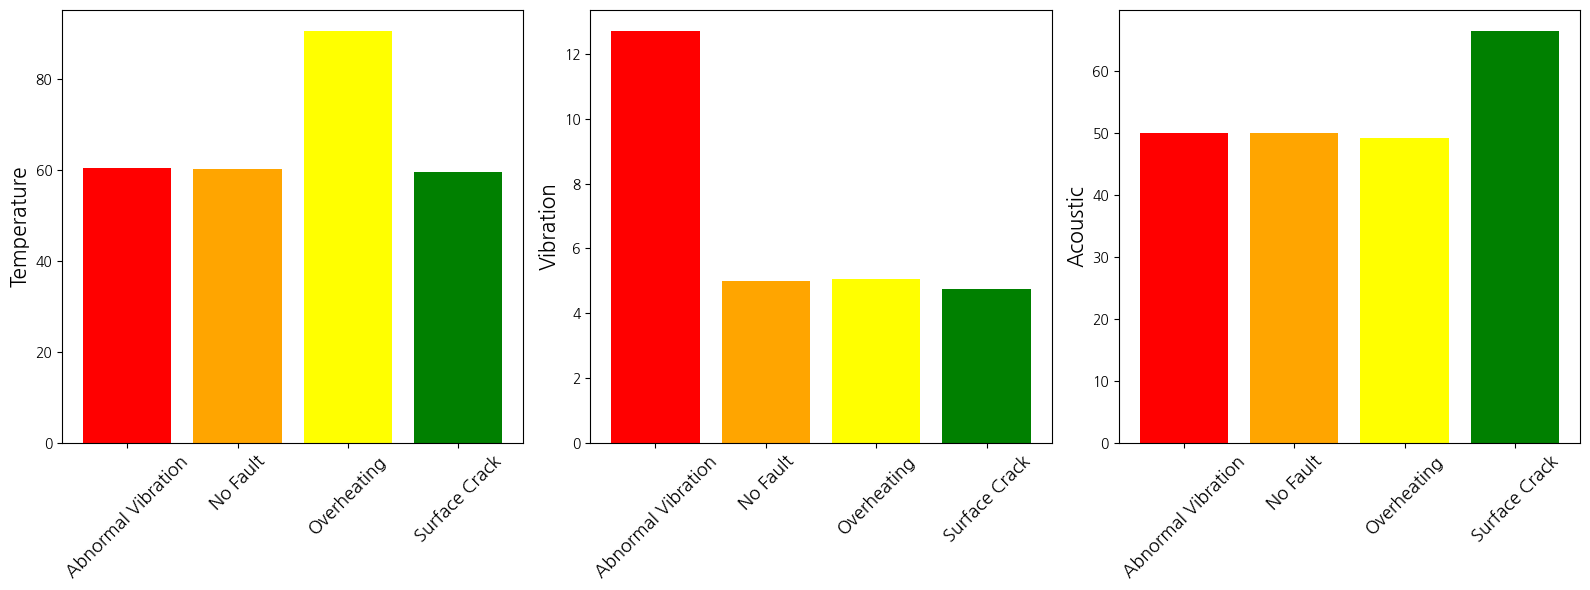

In [89]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

colors = {'Abnormal Vibration':'red',
         'No Fault':'orange',
         'Overheating':'yellow',
         'Surface Crack':'green'}

colors = processedDF.index.map(colors)

ax1.bar(processedDF.index, processedDF['Temperature'], color=colors)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=13)
ax1.set_ylabel('Temperature', fontsize=15)

ax2.bar(processedDF.index, processedDF['Vibration'], color=colors)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=13)
ax2.set_ylabel('Vibration', fontsize=15)

ax3.bar(processedDF.index, processedDF['Acoustic'], color=colors)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, fontsize=13)
ax3.set_ylabel('Acoustic', fontsize=15)

plt.tight_layout()
plt.show()

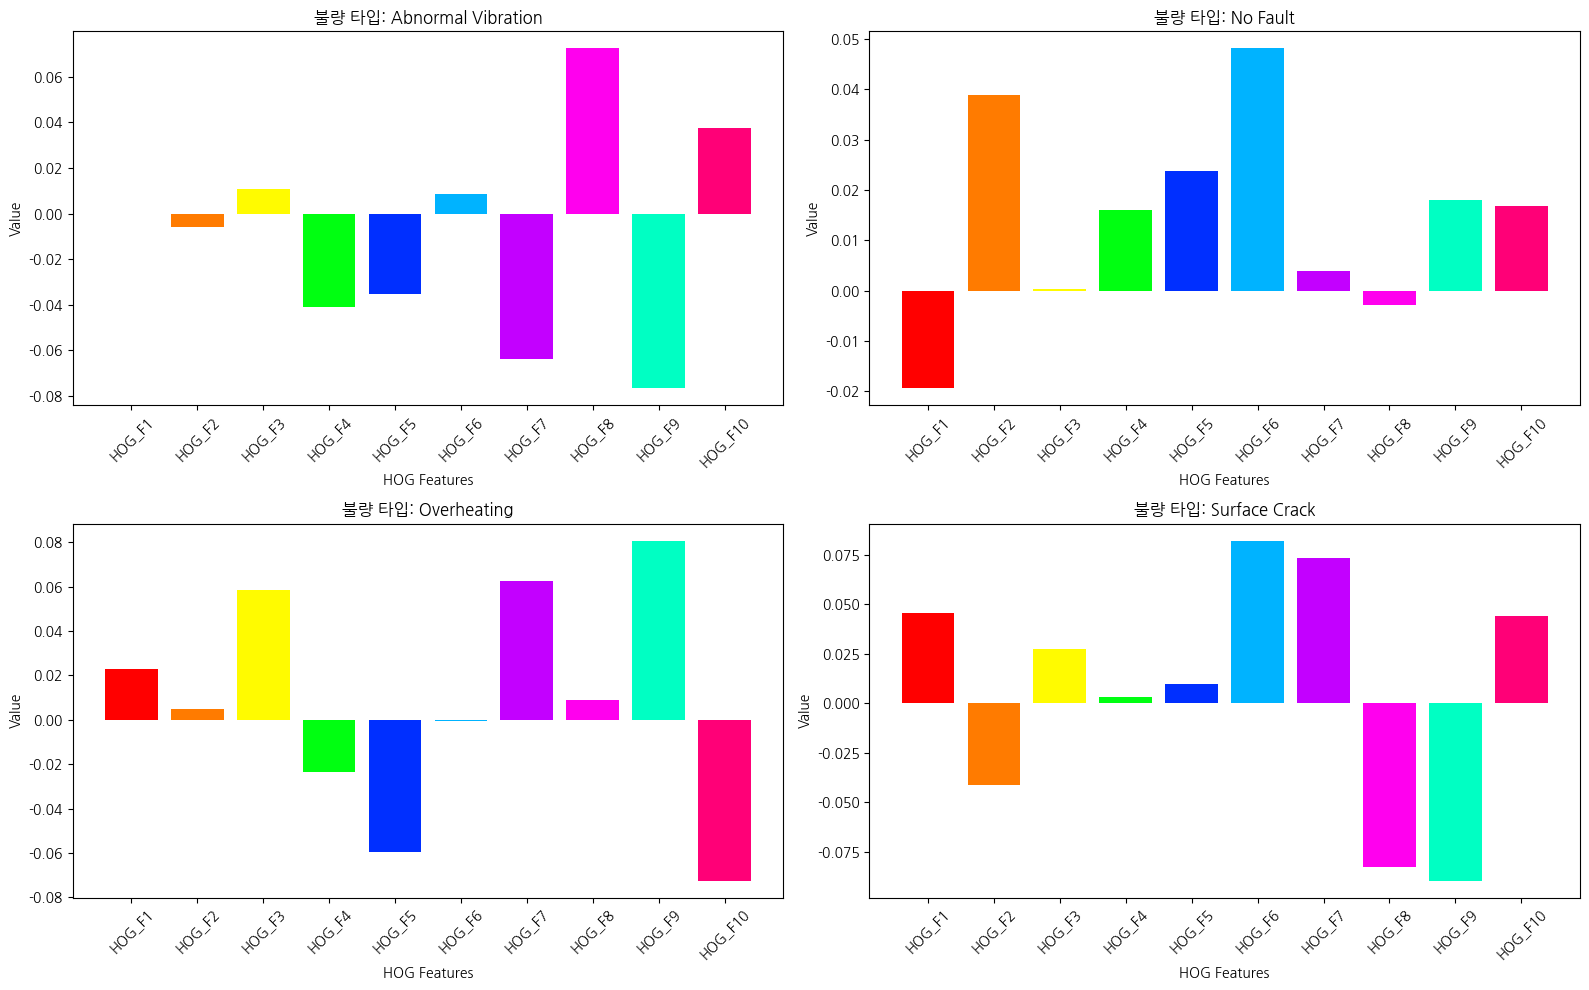

In [91]:
# colors 딕셔너리: 컬럼별 색상 매핑
colors = {
    'HOG_F1': "#ff0000",
    'HOG_F2': "#ff7b00",
    'HOG_F3': "#fffb00",
    'HOG_F4': "#00ff11",
    'HOG_F5': "#002fff",
    'HOG_F6': "#00b3ff",
    'HOG_F7': "#c300ff",
    'HOG_F8': "#ff00ee",
    'HOG_F9': "#00ffc3",
    'HOG_F10': "#ff0077"
}

# 서브플롯 2행 2열 생성
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
# 1차원으로 변경
axs = axs.flatten()     

# 컬럼명 리스트
hog_columns = ['HOG_F1', 'HOG_F2', 'HOG_F3', 'HOG_F4', 'HOG_F5',
               'HOG_F6', 'HOG_F7', 'HOG_F8', 'HOG_F9', 'HOG_F10']

# 그래프 그리기(각 불량타입별로 시각화)
for i, fault_type in enumerate(processedDF.index):
    ax = axs[i]
    values = processedDF.loc[fault_type, hog_columns].values 
    
    bar_colors = [colors[col] for col in hog_columns]
    
    ax.bar(hog_columns, values, color=bar_colors)
    ax.set_title(f'불량 타입: {fault_type}')
    ax.set_xlabel('HOG Features')
    ax.set_ylabel('Value') 
    ax.tick_params(axis='x', rotation=45)
      
# 플롯 간 겹침 방지 및 정리
plt.tight_layout()
plt.show()

인사이트 도출 <hr> 
- 각 결함 유형별 어떤 센서 특성과 표면 패턴 특징 가지는지: 

기온이 높을수록 Overheating 결함이 증가하는 모습을 보였으며, 진동 값이 클수록 Abnormal Vibration 결함이, 소음 센서 값이 클수록 Surface Crack 결함이 증가하는 경향을 나타냈다.

또한 표면 패턴 값인 HOG 데이터를 불량 타입별로 시각화해본 결과, 
불량 타입이 Abnormal Vibration일 때는 HOG-F8 값이 가장 높고 HOG-F9 값이 가장 낮게 나타났다. 

불량 타입이 NO FAULT일 때는 HOG-F6이 가장 높고 HOG-F1이 가장 낮았으며, 

불량 타입이 OVERHEATING일 때는 HOG-F8이 가장 높고 HOG-F10이 가장 낮은 값을 보였다. 

마지막으로 불량 타입이 SURFACE CRACK일 때는 HOG-F6이 가장 높고 HOG-F9가 가장 낮은 패턴을 보여주었다.

- 센서 값만으로 결함 유형 예측 가능한지:

분석 결과, 결함 유형마다 특정 센서 값이 눈에 띄게 증가하는 양상을 보였기 때문에 센서 값만으로도 결함 유형을 어느 정도 예측하는 것이 가능하다고 판단된다.

- 공정 개선 제안 1개 이상:

기온, 진동, 소음 센서 값을 실시간으로 모니터링하여, 각 값이 일정 기준을 초과할 경우 경고를 주거나 해당 제품을 추가적으로 검사가 필요한 대상으로 필터링하는 관리 방식을 도입하는 방식을 제안하고 싶다.